In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tqdm
import sklearn
import skimage.feature
import os, sys
sys.path.append("../")
import savewally
from PIL import Image

# Load training images

## Image 1

Negative features are pretty much selected randomly from the big picture (with only mostly white patches rejected). So homogeneous grass-tiles are incredible frequent (high data redundancy).

## Image 2

A Gaussian Mixture Model was used to cluster negative patches to identify grass-only patches. Subsequent re-engineering of negative patches only accepted GMM-predicted grass patches in only 5% of cases to obtain more samples of the rocky coastline, where most seals are located and more difficult to distinguish from the background.

In [4]:
fp_pos = "../data/patches/StitchMICE_ORKlh16_4_1117_CP_FINAL.tif/positive/"
fp_neg = "../data/patches/StitchMICE_ORKlh16_4_1117_CP_FINAL.tif/negative/"

In [5]:
positive_patches = savewally.read_patches(fp_pos)
negative_patches = savewally.read_patches(fp_neg)

100%|█████████████| 48000/48000 [00:16<00:00, 2834.43it/s]


# Feature engineering

## Histogram of Oriented Gradients

In [6]:
from itertools import chain
patches = np.array([skimage.feature.hog(savewally.RGB2Lum(im)) 
                    for im in chain(positive_patches, 
                                    negative_patches)])

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [7]:
patches_bool = np.zeros(patches.shape[0])
patches_bool[:positive_patches.shape[0]] = 1

## Train-test split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches,
                                                    patches_bool, random_state=0)

print(X_train.shape, X_test.shape)

(38345, 1296) (12782, 1296)


# Training a SVM

In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9886556265484417

In [10]:
grid.best_params_

{'C': 1.0}

In [11]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [12]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     11999
         1.0       0.96      0.85      0.90       783

   micro avg       0.99      0.99      0.99     12782
   macro avg       0.97      0.92      0.95     12782
weighted avg       0.99      0.99      0.99     12782



In [13]:
def plot_slider_prediction(test_image, clf):
    indices, patches = zip(*sliding_window(np.asarray(test_image)))
    
    hogs = []
    for patch in patches:
        greyscale = savewally.RGB2Lum(patch)
        hog_vec = skimage.feature.hog(greyscale, visualize=False)
        hogs.append(hog_vec)
    hogs = np.array(hogs)
    labels = clf.predict(hogs)
    
    Ni, Nj = (40,40)
    indices = np.array(indices)

    fig, ax = plt.subplots(figsize=(20,15))
    ax.imshow(np.asarray(test_image), cmap='gray')
    ax.axis('off')

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='yellow',
                                   alpha=0.3, lw=2, facecolor='none'))
        
    return ax


def sliding_window(img, istep=10, jstep=10, scale=1., patch_size=(50,50)):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


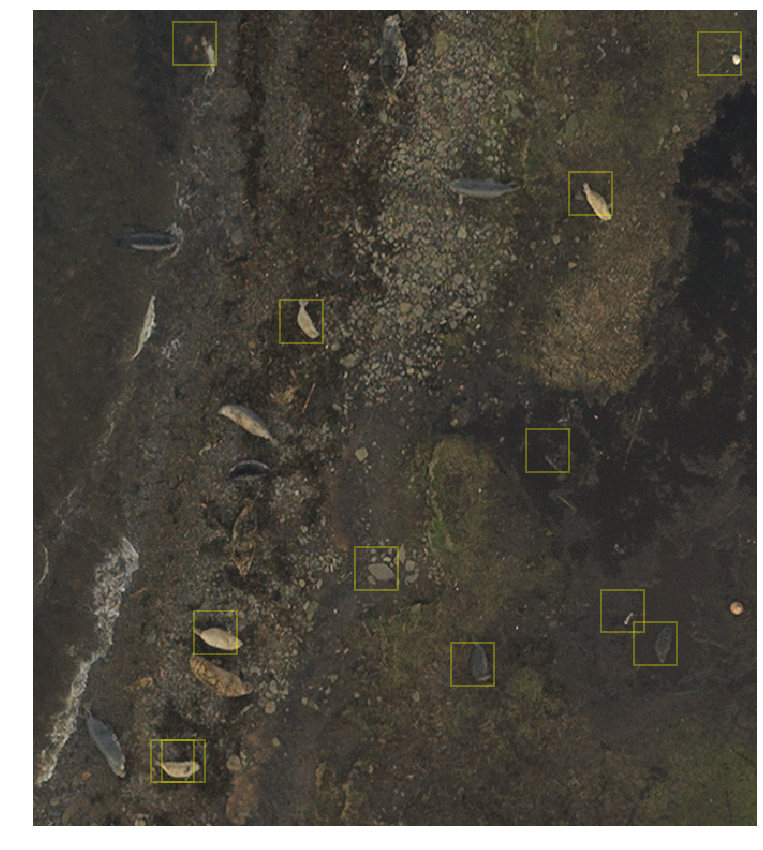

In [17]:
plot_slider_prediction(Image.open("../images/test_image4.png"), model)